In [46]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import rc, rcParams
import matplotlib.lines as mlines
import numpy as np
import scipy
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from decimal import Decimal
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
# plt.style.use('/Users/barbaraskrzypek/Documents/IceCube/LVNeutrinos/LV/paper.mplstyle')

# Coordinate Transformation 

In [47]:
class CoordTransform(object) :

    def __init__(self, detector_lat_deg, detector_long_deg, detector_height_m) :

        self.detector_location = EarthLocation(lat=detector_lat_deg*u.deg, lon=detector_long_deg*u.deg, height=detector_height_m*u.m)


    def get_coszen(self, declination_deg, RA_deg, datetime, utcoffset_hr) : #TODO pass python datetime object
        '''
        Get the cosine of the zenith angle corresponding to the given declination (at the specified date/time)
        Depends on the detector location
        '''

        # Create observation time object
        obs_time = Time(datetime) - (utcoffset_hr*u.hour)

        # Create neutrino direction
        #TODO should this be the opposite direction (e.g. travel direction vs origin direction?)
        nu_dir = SkyCoord(ra=RA_deg*u.deg, dec=declination_deg*u.deg)

        # liv_dir_alt_az_values_day_icecube = liv_dir.transform_to(frame_values_day_icecube)

        # Convert to local coordinate system (zenith, azimuth)
        #TODO what is teh definition of azimuth?
        frame = AltAz(obstime=obs_time, location=self.detector_location)
        nu_dir_alt_az = nu_dir.transform_to(frame)

        # Get zenith angle and convert to cos(zen)
        coszen = np.cos( nu_dir_alt_az.zen.to(u.rad).value )

        #TODO also azimuth

        return coszen


# Sidereal survival probability

In [48]:
meter = 5076142.1319796955
km = meter*1e3
inverseGeV = km*1e9
rEarth = 12742/2
detectorDepth = 1
propHeight = 15
def L(zenith):
    rDetector = rEarth-detectorDepth
    rPropagation = rEarth+detectorDepth+propHeight
    pathlength = - rDetector*np.cos(zenith) +np.sqrt( (rDetector*np.cos(zenith))**2 - rDetector**2 + rPropagation**2 )
    return pathlength

In [49]:
def As(a,c,delta,alpha,E):
    theta = delta+np.pi/2
    phi = np.pi+alpha
    nx = np.sin(theta)*np.cos(phi)
    ny = np.sin(theta)*np.sin(phi)
    a_s = (ny*(a[0]-2*E*c[0]))-(nx*(a[1]-2*E*c[1]))
    return a_s
def Ac(a,c,delta,alpha,E):
    theta = delta+np.pi/2
    phi = np.pi+alpha
    nx = np.sin(theta)*np.cos(phi)
    ny = np.sin(theta)*np.sin(phi)
    a_c = -(nx*(a[0]-2*E*c[0]))-(ny*(a[1]-2*E*c[1]))
    return a_c

In [50]:
def pnunu(a,c,zenith,alpha,E):
    l = L(zenith)*inverseGeV
    delta = zenith-np.deg2rad(90.)
    p = 1-np.square(np.sin(l*(As(a,c,delta,alpha,E)*np.sin(alpha)+Ac(a,c,delta,alpha,E)*np.cos(alpha))))
    assert np.all( p >= 0. )
    assert np.all( p <= 1. )
    return p

# 1D Plots

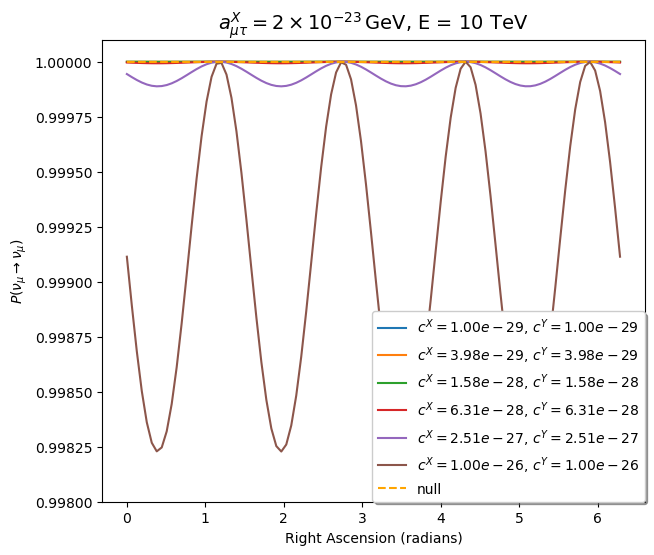

In [51]:
plt.figure(figsize=(7,6))
alphaBins = np.linspace(0,2*np.pi,100)
a = [0,0]
c_array = []
for c in np.logspace(-29,-26,6):
    c_array.append([c,c])
cNull = [0,0]
aNull = [0,0]
probabilitiesNull = []
for c in c_array:
    probabilities = []
    for alpha in alphaBins:
        probabilities.append(pnunu(a,c,np.pi/3,alpha,1e4))
    plt.plot(alphaBins,probabilities,label = r'$c^X = {:.2e}$'.format(c[0])+r', $c^Y = {:.2e}$'.format(c[1]))
for alpha in alphaBins:
    probabilitiesNull.append(pnunu(aNull,cNull,np.pi/3,alpha,1e4))
plt.plot(alphaBins,probabilitiesNull,color = 'orange',ls = '--',label = 'null')
#plt.xscale('log')
plt.xlabel("Right Ascension (radians)")
plt.title(r"$a_{\mu\tau}^X = 2\times 10^{-23}\, \rm GeV$, E = 10 TeV",fontsize = 14)
plt.ylabel(r"$P(\nu_{\mu}\rightarrow \nu_{\mu})$")
plt.ylim(0.998,1.0001)
plt.legend( loc='lower right', borderaxespad=0.,frameon = True,shadow = True)
plt.show()

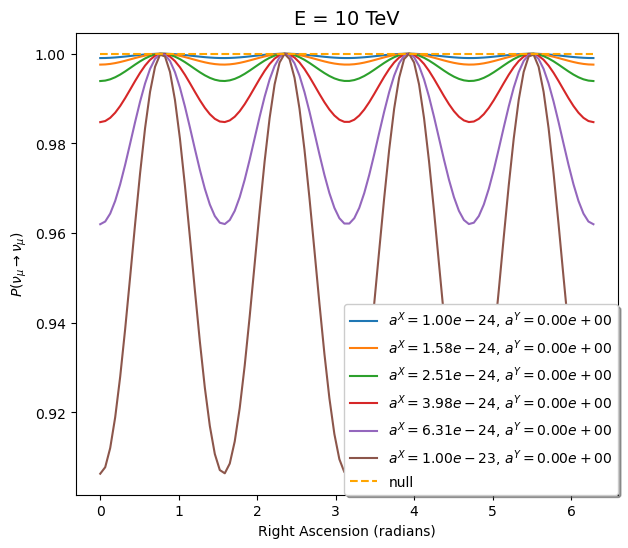

In [52]:
plt.figure(figsize=(7,6))
alphaBins = np.linspace(0,2*np.pi,100)
a_array = []
c = [0,0]
for a in np.logspace(-24,-23,6):
    a_array.append([a,0])
cNull = [0,0]
aNull = [0,0]
probabilitiesNull = []
for a in a_array:
    probabilities = []
    for alpha in alphaBins:
        probabilities.append(pnunu(a,c,np.arccos(-0.8),alpha,1e4))
    plt.plot(alphaBins,probabilities,label = r'$a^X = {:.2e}$'.format(a[0])+r', $a^Y = {:.2e}$'.format(a[1]))
for alpha in alphaBins:
    probabilitiesNull.append(pnunu(aNull,cNull,np.pi/3,alpha,1e4))
plt.plot(alphaBins,probabilitiesNull,color = 'orange',ls = '--',label = 'null')
#plt.xscale('log')
plt.xlabel("Right Ascension (radians)")
plt.title(r"E = 10 TeV",fontsize = 14)
plt.ylabel(r"$P(\nu_{\mu}\rightarrow \nu_{\mu})$")
plt.legend( loc='lower right', borderaxespad=0.,frameon = True,shadow = True)
plt.show()

In [53]:
plt.figure(figsize=(9,6))
alphaBins = np.linspace(0,2*np.pi,500)
a_array = []
c = [0,0]
for a in np.logspace(-24,-23,6):
    a_array.append([a,a])
cNull = [0,0]
aNull = [0,0]
probabilitiesNull = []
for a in a_array:
    probabilities = []
    for alpha in alphaBins:
        probabilities.append(pnunu(a,c,np.arccos(-0.8),alpha,1e4))
    plt.plot(alphaBins,probabilities,label = r'$a^X = {:.2e}$'.format(a[0])+r', $a^Y = {:.2e}$'.format(a[1]))
for alpha in alphaBins:
    probabilitiesNull.append(pnunu(aNull,cNull,np.pi/3,alpha,1e4))
plt.plot(alphaBins,probabilitiesNull,color = 'orange',ls = '--',label = 'null')
#plt.xscale('log')
plt.xlabel("Right Ascension (radians)")
plt.title(r"E = 10 TeV",fontsize = 14)
plt.ylabel(r"$P(\nu_{\mu}\rightarrow \nu_{\mu})$")
plt.legend( loc='lower right', borderaxespad=0.,frameon = True,shadow = True)
plt.savefig("ProbRA_dim3.pdf",dpi = 400,bbox_inches = "tight")
plt.show()

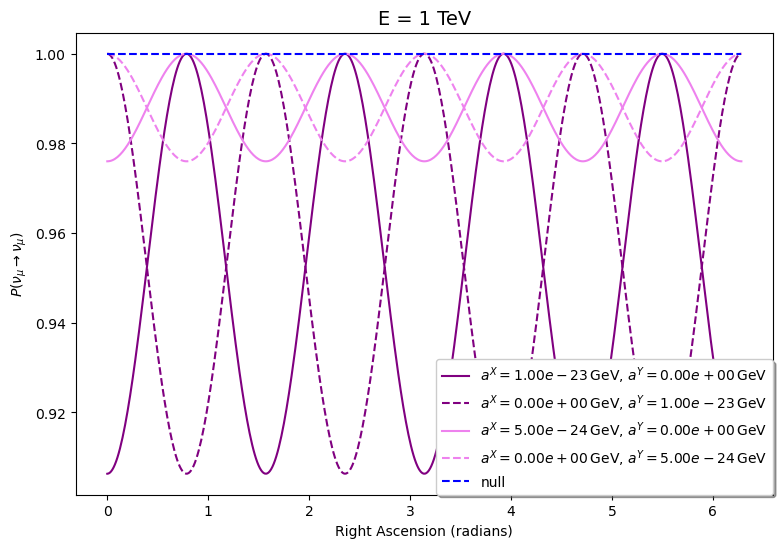

In [54]:
plt.figure(figsize=(9,6))
alphaBins = np.linspace(0,2*np.pi,500)
a_array_x = []
a_array_y = []
c = [0,0]

cm =plt.get_cmap('RdPu')
color_min = 0.1
color_max = 0.9
color_range = color_max-color_min
#colors = [cm(color_range*i/(2-1)+color_min) for i in range(2)]
colors = ['purple','violet']

for a in [1e-23,0.5e-23]:
    a_array_x.append([a,0])
    a_array_y.append([0,a])
cNull = [0,0]
aNull = [0,0]
probabilitiesNull = []
for i in range(2):
    ax = a_array_x[i]
    ay = a_array_y[i]
    probabilities_x = []
    probabilities_y = []
    for alpha in alphaBins:
        probabilities_x.append(pnunu(a_array_x[i],c,np.arccos(-0.8),alpha,1e3))
        probabilities_y.append(pnunu(a_array_y[i],c,np.arccos(-0.8),alpha,1e3))
    plt.plot(alphaBins,probabilities_x,label = r'$a^X = {:.2e} \, \rm GeV$'.format(ax[0])+r', $a^Y = {:.2e} \, \rm GeV$'.format(ax[1]),color = colors[i])
    plt.plot(alphaBins,probabilities_y,label = r'$a^X = {:.2e} \, \rm GeV$'.format(ay[0])+r', $a^Y = {:.2e} \, \rm GeV$'.format(ay[1]),ls = '--',color = colors[i])
for alpha in alphaBins:
    probabilitiesNull.append(pnunu(aNull,cNull,np.pi/3,alpha,1e3))
plt.plot(alphaBins,probabilitiesNull,color = 'blue',ls = '--',label = 'null')
#plt.xscale('log')
plt.xlabel("Right Ascension (radians)")
plt.title(r"E = 1 TeV",fontsize = 14)
plt.ylabel(r"$P(\nu_{\mu}\rightarrow \nu_{\mu})$")
plt.legend( loc='lower right', borderaxespad=0.,frameon = True,shadow = True)
plt.savefig("ProbRA_dim3_2.png",dpi = 400,bbox_inches = "tight")
plt.show()

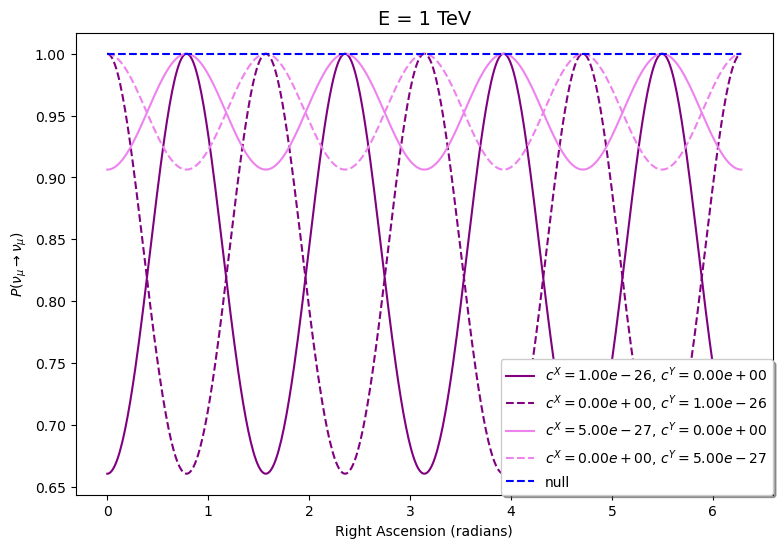

In [55]:
plt.figure(figsize=(9,6))
alphaBins = np.linspace(0,2*np.pi,500)
c_array_x = []
c_array_y = []
a = [0,0]

cm =plt.get_cmap('RdPu')
color_min = 0.1
color_max = 0.9
color_range = color_max-color_min
#colors = [cm(color_range*i/(2-1)+color_min) for i in range(2)]
colors = ['purple','violet']

for c in [1e-26,0.5e-26]:
    c_array_x.append([c,0])
    c_array_y.append([0,c])
cNull = [0,0]
aNull = [0,0]
probabilitiesNull = []
for i in range(2):
    cx = c_array_x[i]
    cy = c_array_y[i]
    probabilities_x = []
    probabilities_y = []
    for alpha in alphaBins:
        probabilities_x.append(pnunu(a,c_array_x[i],np.arccos(-0.8),alpha,1e3))
        probabilities_y.append(pnunu(a,c_array_y[i],np.arccos(-0.8),alpha,1e3))
    plt.plot(alphaBins,probabilities_x,label = r'$c^X = {:.2e}$'.format(cx[0])+r', $c^Y = {:.2e}$'.format(cx[1]),color = colors[i])
    plt.plot(alphaBins,probabilities_y,label = r'$c^X = {:.2e}$'.format(cy[0])+r', $c^Y = {:.2e}$'.format(cy[1]),ls = '--',color = colors[i])
for alpha in alphaBins:
    probabilitiesNull.append(pnunu(aNull,cNull,np.pi/3,alpha,1e3))
plt.plot(alphaBins,probabilitiesNull,color = 'blue',ls = '--',label = 'null')
#plt.xscale('log')
plt.xlabel("Right Ascension (radians)")
plt.title(r"E = 1 TeV",fontsize = 14)
plt.ylabel(r"$P(\nu_{\mu}\rightarrow \nu_{\mu})$")
plt.legend( loc='lower right', borderaxespad=0.,frameon = True,shadow = True,framealpha = 1)
plt.savefig("ProbRA_dim4.png",dpi = 400,bbox_inches = "tight")
plt.show()

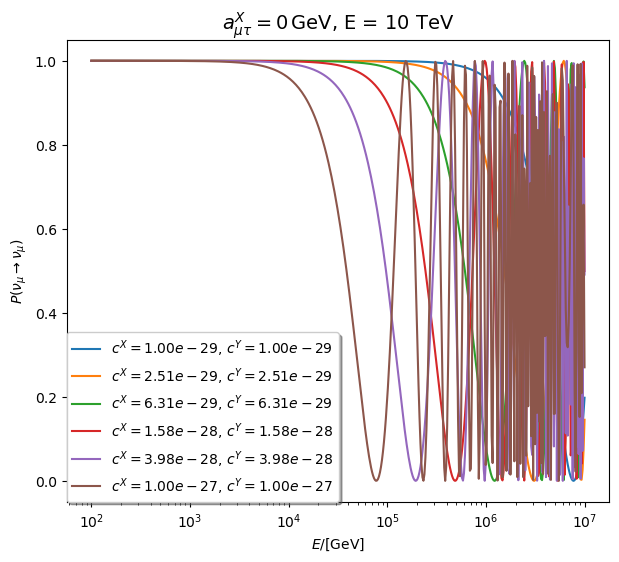

In [56]:
plt.figure(figsize=(7,6))
EBins = np.logspace(2,7,500)
a = [0,0]
c_array = []
for c in np.logspace(-29,-27,6):
    c_array.append([c,c])
cNull = [0,0]
aNull = [0,0]
probabilitiesNull = []
for c in c_array:
    probabilities = []
    for E in EBins:
        probabilities.append(pnunu(a,c,np.arccos(-0.1),2,E))
    plt.plot(EBins, probabilities,label = r'$c^X = {:.2e}$'.format(c[0])+r', $c^Y = {:.2e}$'.format(c[1]))
for E in EBins:
    probabilitiesNull.append(pnunu(aNull,cNull,np.pi/3,2,E))
#plt.plot(EBins,probabilitiesNull,color = 'orange',ls = '--',label = 'null')
#plt.xscale('log')
plt.xlabel(r"$E/[\rm GeV]$")
plt.xscale('log')
plt.title(r"$a_{\mu\tau}^X = 0\, \rm GeV$, E = 10 TeV",fontsize = 14)
plt.ylabel(r"$P(\nu_{\mu}\rightarrow \nu_{\mu})$")
plt.legend( loc='lower left', borderaxespad=0.,frameon = True,shadow = True)
plt.show()

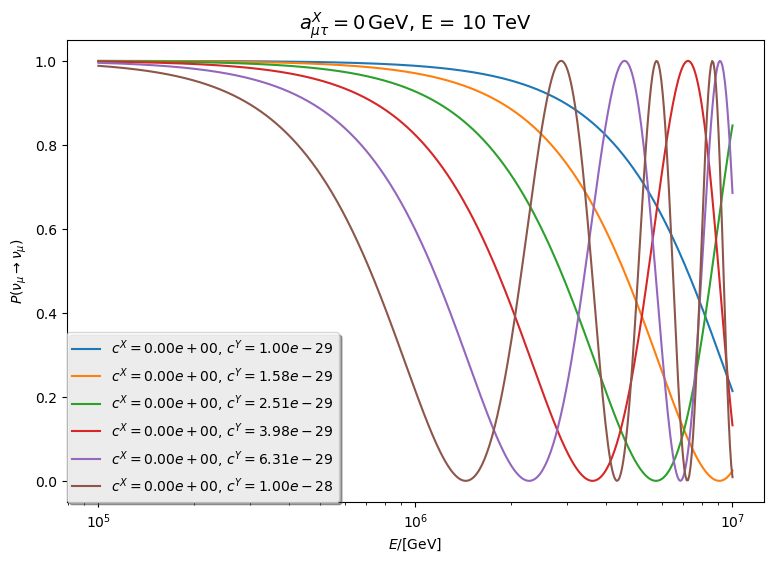

In [57]:
plt.figure(figsize=(9,6))
EBins = np.logspace(5,7,500)
a = [0,0]
c_array = []
for c in np.logspace(-29,-28,6):
    c_array.append([0,c])
cNull = [0,0]
aNull = [0,0]
probabilitiesNull = []
for c in c_array:
    probabilities = []
    for E in EBins:
        probabilities.append(pnunu(a,c,np.arccos(-0.1),2,E))
    plt.plot(EBins,probabilities,label = r'$c^X = {:.2e}$'.format(c[0])+r', $c^Y = {:.2e}$'.format(c[1]))
for E in EBins:
    probabilitiesNull.append(pnunu(aNull,cNull,np.pi/3,2,E))
#plt.plot(EBins,probabilitiesNull,color = 'orange',ls = '--',label = 'null')
#plt.xscale('log')
plt.xlabel(r"$E/[\rm GeV]$")
plt.xscale('log')
plt.title(r"$a_{\mu\tau}^X = 0\, \rm GeV$, E = 10 TeV",fontsize = 14)
plt.ylabel(r"$P(\nu_{\mu}\rightarrow \nu_{\mu})$")
plt.legend( loc='lower left', borderaxespad=0.,frameon = True,shadow = True,framealpha = 0.8)
plt.show()

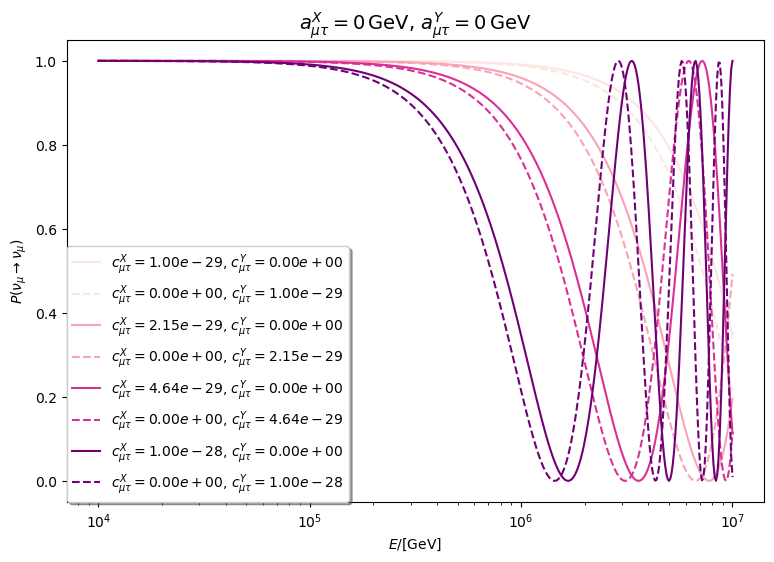

In [58]:
plt.figure(figsize=(9,6))
EBins = np.logspace(4,7,500)
a = [0,0]
c_array_x = []
c_array_y = []

cNull = [0,0]
aNull = [0,0]

cm =plt.get_cmap('RdPu')
color_min = 0.1
color_max = 0.9
color_range = color_max-color_min
colors = [cm(color_range*i/(4-1)+color_min) for i in range(4)]

for c in np.logspace(-29,-28,4):
    c_array_x.append([c,0])
    c_array_y.append([0,c])
    
cNull = [0,0]
aNull = [0,0]
probabilitiesNull = []

for i in range(4):
    cx = c_array_x[i]
    cy = c_array_y[i]
    probabilities_x = []
    probabilities_y = []
    for E in EBins:
        probabilities_x.append(pnunu(a,c_array_x[i],np.arccos(-0.1),2,E))
        probabilities_y.append(pnunu(a,c_array_y[i],np.arccos(-0.1),2,E))
    plt.plot(EBins,probabilities_x,label = r'$c_{\mu\tau}^X$'+ r'$= {:.2e}$'.format(cx[0])+r', $c_{\mu\tau}^Y$'+ r'$= {:.2e}$'.format(cx[1]),color = colors[i])
    plt.plot(EBins,probabilities_y,label = r'$c_{\mu\tau}^X$'+ r'$= {:.2e}$'.format(cy[0])+r', $c_{\mu\tau}^Y$'+ r'$= {:.2e}$'.format(cy[1]),ls = '--',color = colors[i])
#for E in Ebins:
#    probabilitiesNull.append(pnunu(aNull,cNull,np.pi/3,2,E))
#plt.plot(EBins,probabilitiesNull,color = 'orange',ls = '--',label = 'null')
#plt.xscale('log')
plt.xlabel(r"$E/[\rm GeV]$")
plt.xscale('log')
plt.title(r"$a_{\mu\tau}^X = 0\, \rm GeV$, $a_{\mu\tau}^Y = 0\, \rm GeV$",fontsize = 14)
plt.ylabel(r"$P(\nu_{\mu}\rightarrow \nu_{\mu})$")
plt.legend( loc='lower left', borderaxespad=0.,frameon = True,shadow = True,framealpha = 1)
plt.savefig("ProbEnergy_dim4.pdf",dpi = 400,bbox_inches = "tight")
plt.show()

# 2D Plots

In [59]:
def MakeRAEnergyPlot(a,c):
    plt.figure(figsize=(9,6))
    Ebins = np.linspace(2,6,500)
    alphaBins = np.linspace(0,2*np.pi,500)
    probabilities2d = np.zeros((500,500))
    for i in range(500): 
        for j in range(500): 
            probabilities2d[i,j] = pnunu(a,c,np.arccos(-0.8),alphaBins[i],10**(Ebins[j]))
    plt.imshow(probabilities2d[::-1],aspect = 'auto',extent = [2,6,0,2*np.pi],cmap = 'RdPu')
    plt.colorbar(label = r'$P(\nu_{\mu}\rightarrow \nu_{\mu})$')
    plt.xlabel(r'$\log_{10}(E/[\rm GeV])$')
    plt.ylabel("Right Ascension")
    string = r'$a^X = {:.2e} \, \rm GeV$'.format(a[0])+r', $a^Y = {:.2e} \, \rm GeV$'.format(a[1])+r', $c^X = {:.2e}$'.format(c[0])+r', $c^Y = {:.2e}$'.format(c[1])
    plt.title(r'$a^X = {:.2e} \, \rm GeV$'.format(a[0])+r', $a^Y = {:.2e} \, \rm GeV$'.format(a[1])+r', $c^X = {:.2e}$'.format(c[0])+r', $c^Y = {:.2e}$'.format(c[1]),fontsize = 14)
    plt.savefig("RAEnergy"+string+".png",dpi = 400,bbox_inches = "tight")
    plt.show()

In [60]:
def MakeRACosZenithPlot(a,c,E):
    plt.figure(figsize=(10,6))
    zenithBins = np.linspace(-1,1,500)
    alphaBins = np.linspace(0,2*np.pi,500)
    probabilities2d = np.zeros((500,500))
    for i in range(500): 
        for j in range(500): 
            probabilities2d[i,j] = pnunu(a,c,np.arccos(zenithBins[j]),alphaBins[i],E)
    plt.imshow(probabilities2d[::-1],aspect = 'auto',extent = [-1,1,0,2*np.pi],cmap = 'RdPu')
    plt.colorbar(label = r'$P(\nu_{\mu}\rightarrow \nu_{\mu})$')
    plt.xlabel(r'$\log_{10}(E/[\rm GeV])$')
    plt.ylabel(r"$\cos(\theta)$")
    string = r'$a^X = {:.2e} \, \rm GeV$'.format(a[0])+r', $a^Y = {:.2e} \, \rm GeV$'.format(a[1])+r', $c^X = {:.2e}$'.format(c[0])+r', $c^Y = {:.2e}$'.format(c[1])+r', $E = {:.2e}\, \rm GeV$'.format(E)
    plt.title(string,fontsize = 14)
    plt.savefig("RACosZenith"+string+".pdf",dpi = 400,bbox_inches = "tight")
    plt.show()

In [61]:
def MakeEnergyCosZenithPlot(a,c):
    plt.figure(figsize=(10,6))
    zenithBins = np.linspace(-1,1,500)
    EBins = np.linspace(2,5,500)
    probabilities2d = np.zeros((500,500))
    for i in range(500): 
        for j in range(500): 
            probabilities2d[i,j] = pnunu(a,c,np.arccos(zenithBins[i]),3,10**(EBins[j]))
    plt.imshow(probabilities2d[::-1],aspect = 'auto',extent = [2,5,-1,1],cmap = 'RdPu')
    plt.colorbar(label = r'$P(\nu_{\mu}\rightarrow \nu_{\mu})$')
    plt.xlabel(r'$\log_{10}(E/[\rm GeV])$')
    plt.ylabel(r"$\cos(\theta_z)$")
    string = r'$a^X = {:.2e} \, \rm GeV$'.format(a[0])+r', $a^Y = {:.2e} \, \rm GeV$'.format(a[1])+r', $c^X = {:.2e}$'.format(c[0])+r', $c^Y = {:.2e}$'.format(c[1])
    plt.title(string,fontsize = 14)
    plt.savefig("EnergyCosZenith"+string+".png",dpi = 400,bbox_inches = "tight")
    plt.show()

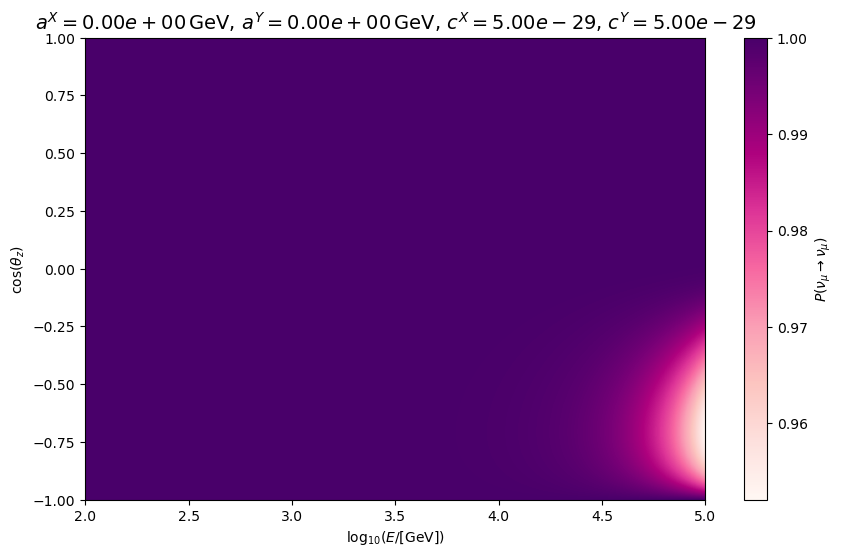

In [62]:
MakeEnergyCosZenithPlot([0,0],[5e-29,5e-29])

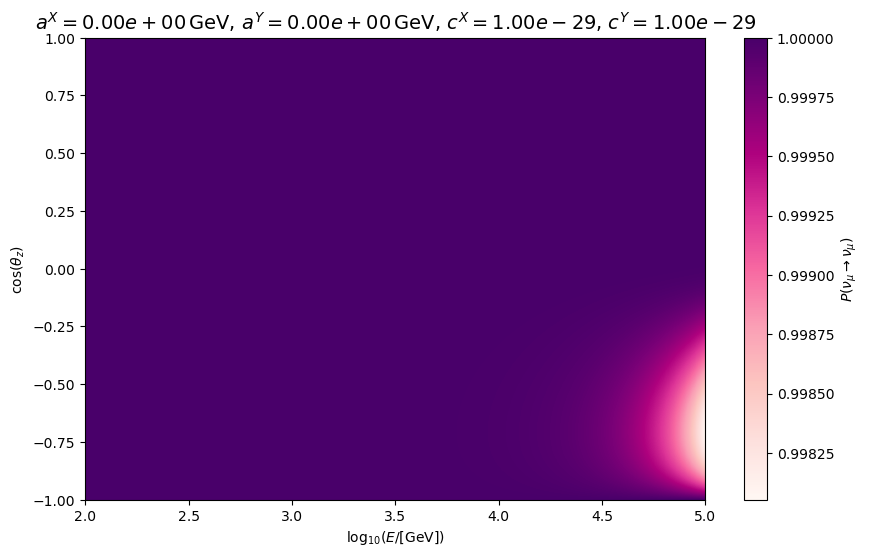

In [63]:
MakeEnergyCosZenithPlot([0,0],[1e-29,1e-29])

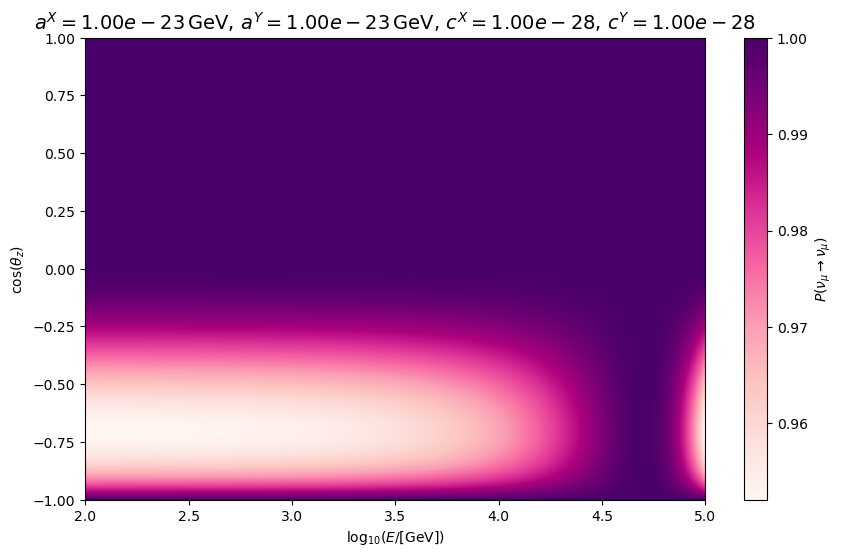

In [64]:
MakeEnergyCosZenithPlot([1e-23,1e-23],[1e-28,1e-28])

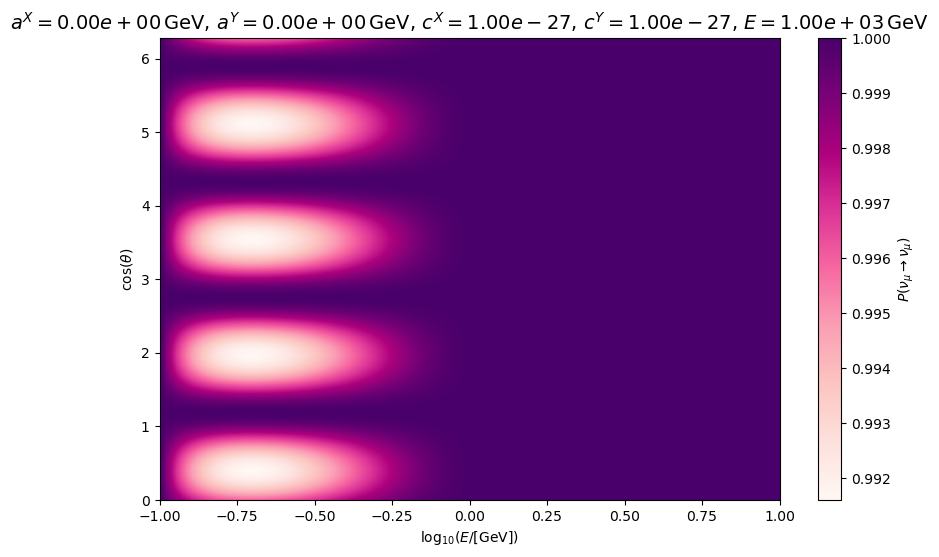

In [65]:
MakeRACosZenithPlot([0,0],[1e-27,1e-27],1e3)

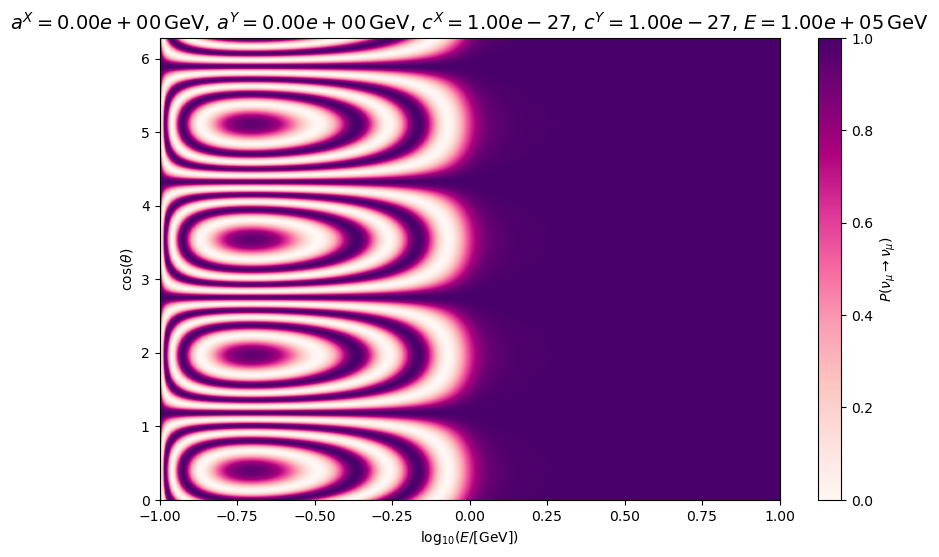

In [66]:
MakeRACosZenithPlot([0,0],[1e-27,1e-27],1e5)

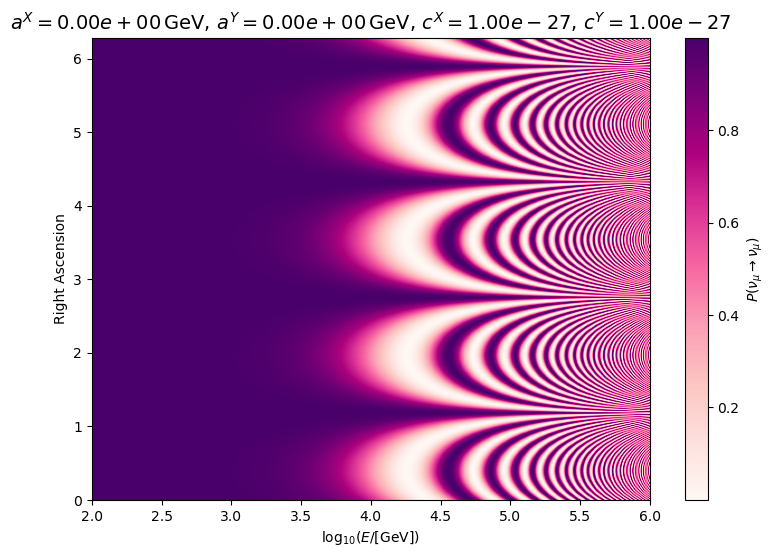

In [67]:
MakeRAEnergyPlot([0,0],[1e-27,1e-27])

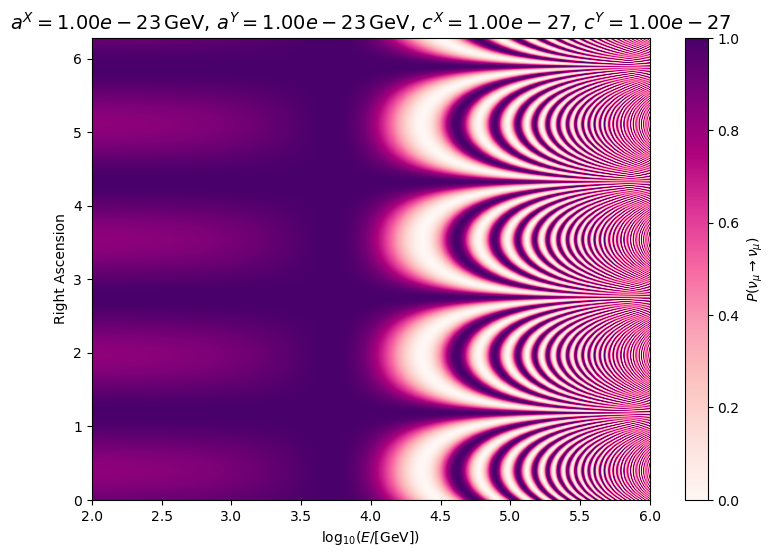

In [68]:
MakeRAEnergyPlot([1e-23,1e-23],[1e-27,1e-27])

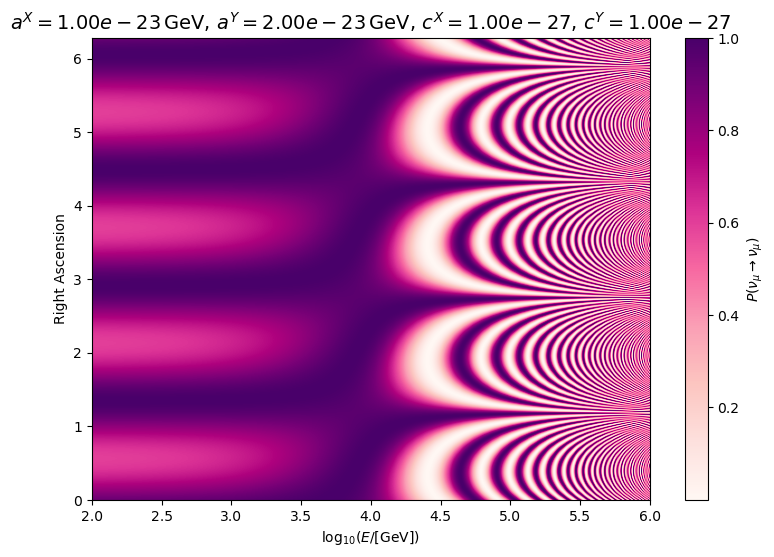

In [69]:
MakeRAEnergyPlot([1e-23,2e-23],[1e-27,1e-27])

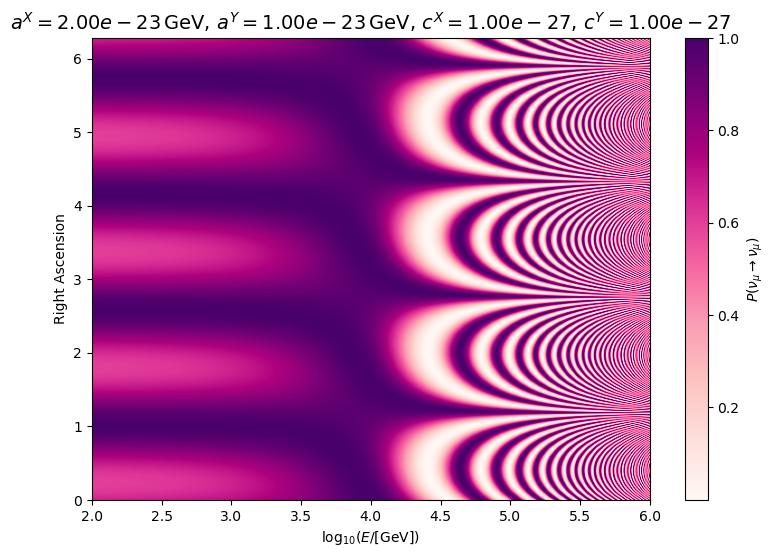

In [70]:
MakeRAEnergyPlot([2e-23,1e-23],[1e-27,1e-27])

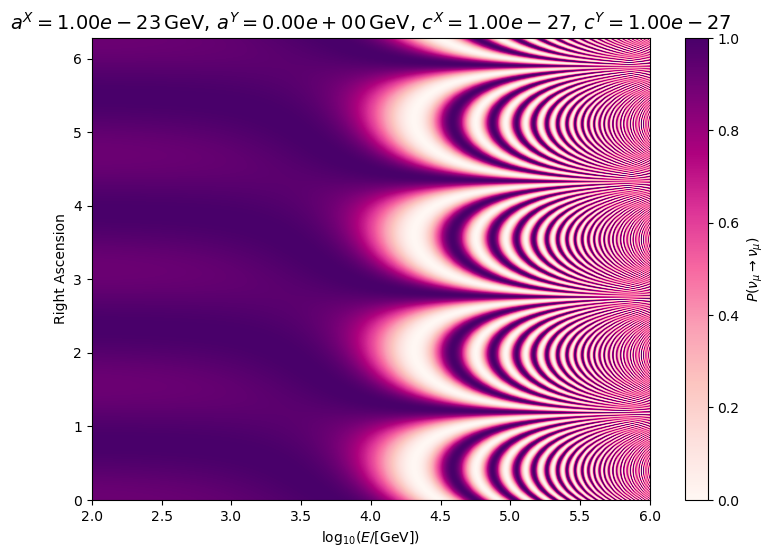

In [71]:
MakeRAEnergyPlot([1e-23,0],[1e-27,1e-27])

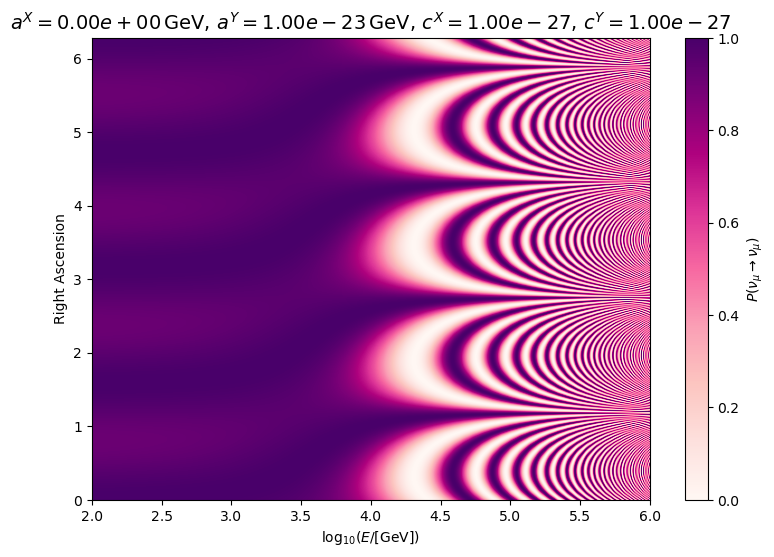

In [72]:
MakeRAEnergyPlot([0,1e-23],[1e-27,1e-27])

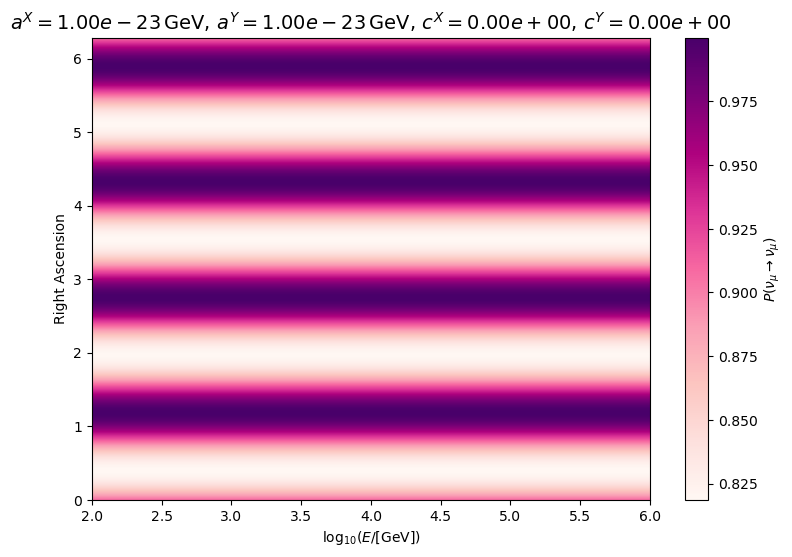

In [73]:
MakeRAEnergyPlot([1e-23,1e-23],[0,0])

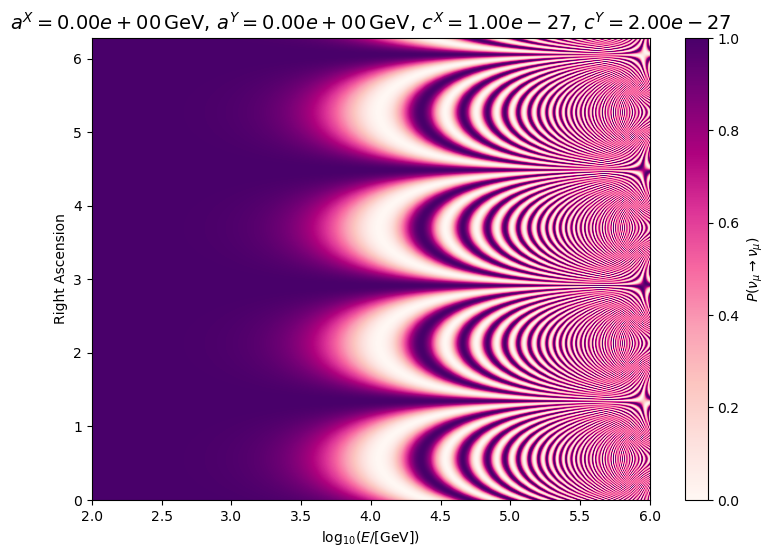

In [74]:
MakeRAEnergyPlot([0,0],[1e-27,2e-27])

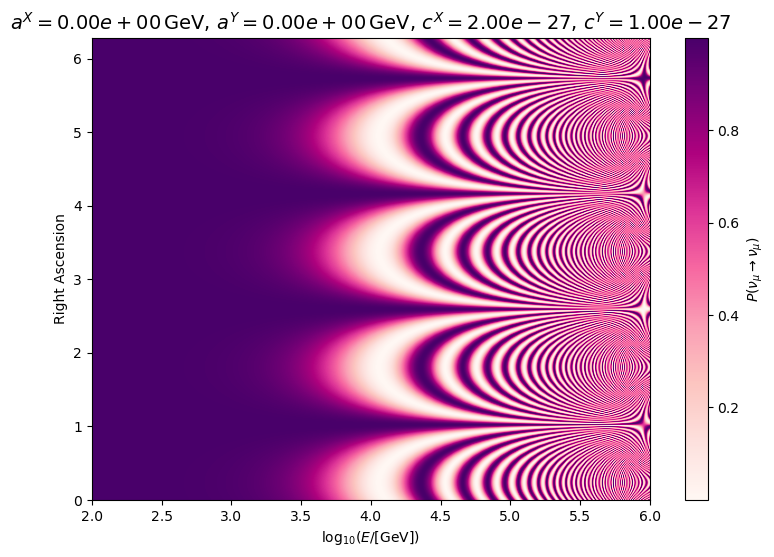

In [75]:
MakeRAEnergyPlot([0,0],[2e-27,1e-27])

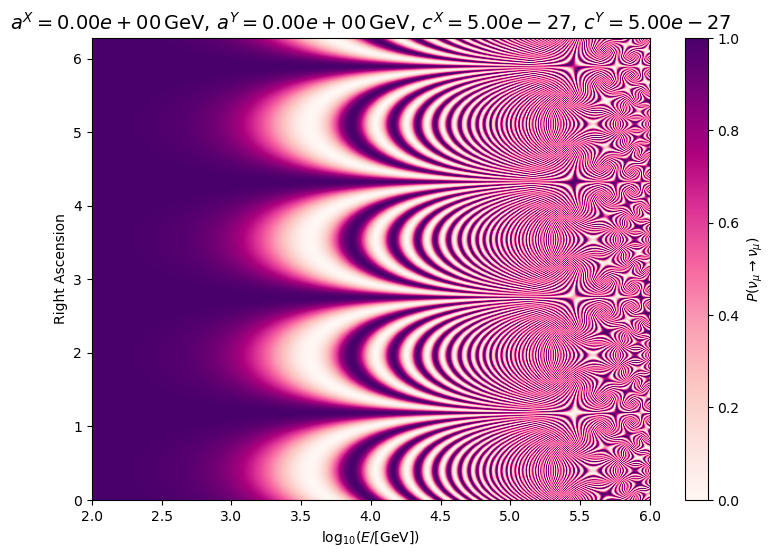

In [76]:
MakeRAEnergyPlot([0,0],[5e-27,5e-27])

In [77]:
MakeRAEnergyPlot([0,0],[1e-28,1e-28])

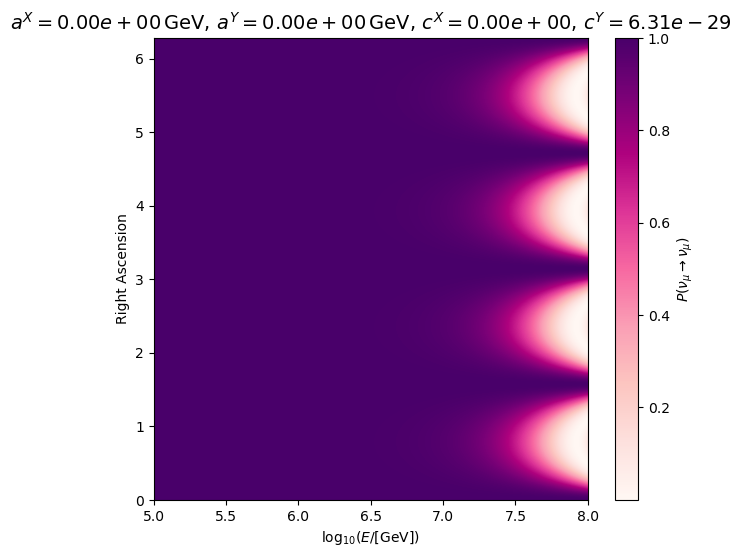

In [78]:
plt.figure(figsize=(7,6))
Ebins = np.linspace(5,8,500)
alphaBins = np.linspace(0,2*np.pi,500)
probabilities2d = np.zeros((500,500))
a = [0,0]
c = c_array[4]
for i in range(500): 
    for j in range(500): 
        probabilities2d[i,j] = pnunu(a,c,np.pi/3,alphaBins[i],10**(Ebins[j]))
#hist = np.histogram2d(zenithBins,alphaBins,bins = [zenithBins,alphaBins],weights = probabilities2d)
plt.imshow(probabilities2d,aspect = 'auto',extent = [5,8,0,2*np.pi],cmap = 'RdPu')
plt.colorbar(label = r'$P(\nu_{\mu}\rightarrow \nu_{\mu})$')
plt.xlabel(r'$\log_{10}(E/[\rm GeV])$')
plt.ylabel("Right Ascension")
plt.title(r'$a^X = {:.2e} \, \rm GeV$'.format(a[0])+r', $a^Y = {:.2e} \, \rm GeV$'.format(a[1])+r', $c^X = {:.2e}$'.format(c[0])+r', $c^Y = {:.2e}$'.format(c[1]),fontsize = 14)
plt.show()

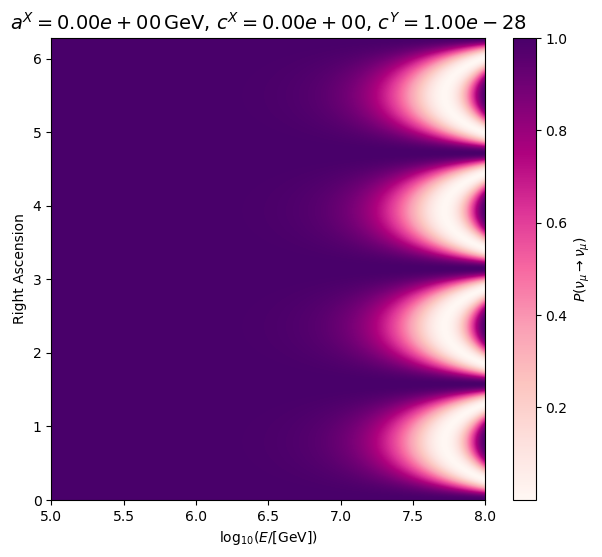

In [79]:
plt.figure(figsize=(7,6))
Ebins = np.linspace(5,8,500)
alphaBins = np.linspace(0,2*np.pi,500)
probabilities2d = np.zeros((500,500))
a = [0,0]
c = c_array[5]
for i in range(500): 
    for j in range(500): 
        probabilities2d[i,j] = pnunu(a,c,np.pi/3,alphaBins[i],10**(Ebins[j]))
#hist = np.histogram2d(zenithBins,alphaBins,bins = [zenithBins,alphaBins],weights = probabilities2d)
plt.imshow(probabilities2d,aspect = 'auto',extent = [5,8,0,2*np.pi],cmap = 'RdPu')
plt.colorbar(label = r'$P(\nu_{\mu}\rightarrow \nu_{\mu})$')
plt.xlabel(r'$\log_{10}(E/[\rm GeV])$')
plt.ylabel("Right Ascension")
plt.title(r'$a^X = {:.2e} \, \rm GeV$'.format(a[0])+r', $c^X = {:.2e}$'.format(c[0])+r', $c^Y = {:.2e}$'.format(c[1]),fontsize = 14)
plt.show()

In [80]:
plt.figure(figsize=(7,6))
Ebins = np.linspace(5,7,500)
alphaBins = np.linspace(0,2*np.pi,500)
probabilities2d = np.zeros((500,500))
a = [0,0]
c = [1e-27,3e-27]
for i in range(500): 
    for j in range(500): 
        probabilities2d[i,j] = pnunu(a,c,np.pi/3,alphaBins[i],10**(Ebins[j]))
#hist = np.histogram2d(zenithBins,alphaBins,bins = [zenithBins,alphaBins],weights = probabilities2d)
plt.imshow(probabilities2d,aspect = 'auto',extent = [5,7,0,2*np.pi],cmap = 'RdPu')
plt.colorbar(label = r'$P(\nu_{\mu}\rightarrow \nu_{\mu})$')
plt.xlabel(r'$\log_{10}(E/[\rm GeV])$')
plt.ylabel("Right Ascension")
plt.title(r'$a^X = {:.2e} \, \rm GeV$'.format(a[0])+r', $c^X = {:.2e}$'.format(c[0])+r', $c^Y = {:.2e}$'.format(c[1]),fontsize = 14)
plt.show()

In [81]:
plt.figure(figsize=(7,6))
Ebins = np.linspace(4,7,500)
alphaBins = np.linspace(0,2*np.pi,500)
probabilities2d = np.zeros((500,500))
a = [0,0]
c = [1e-26,1e-26]
for i in range(500): 
    for j in range(500): 
        probabilities2d[i,j] = pnunu(a,c,np.pi/3,alphaBins[i],10**(Ebins[j]))
#hist = np.histogram2d(zenithBins,alphaBins,bins = [zenithBins,alphaBins],weights = probabilities2d)
plt.imshow(probabilities2d,aspect = 'auto',extent = [4,7,0,2*np.pi],cmap = 'RdPu')
plt.colorbar(label = r'$P(\nu_{\mu}\rightarrow \nu_{\mu})$')
plt.xlabel(r'$\log_{10}(E/[\rm GeV])$')
plt.ylabel("Right Ascension")
plt.title(r'$a^X = {:.2e} \, \rm GeV$'.format(a[0])+r', $c^X = {:.2e}$'.format(c[0])+r', $c^Y = {:.2e}$'.format(c[1]),fontsize = 14)
plt.show()

In [82]:
plt.figure(figsize=(7,6))
Ebins = np.linspace(4,7,500)
alphaBins = np.linspace(0,2*np.pi,500)
probabilities2d = np.zeros((500,500))
a = [0,0]
c = [1e-26,0]
for i in range(500): 
    for j in range(500): 
        probabilities2d[i,j] = pnunu(a,c,np.pi/3,alphaBins[i],10**(Ebins[j]))
#hist = np.histogram2d(zenithBins,alphaBins,bins = [zenithBins,alphaBins],weights = probabilities2d)
plt.imshow(probabilities2d,aspect = 'auto',extent = [4,7,0,2*np.pi],cmap = 'RdPu')
plt.colorbar(label = r'$P(\nu_{\mu}\rightarrow \nu_{\mu})$')
plt.xlabel(r'$\log_{10}(E/[\rm GeV])$')
plt.ylabel("Right Ascension")
plt.title(r'$a^X = {:.2e} \, \rm GeV$'.format(a[0])+r', $c^X = {:.2e}$'.format(c[0])+r', $c^Y = {:.2e}$'.format(c[1]),fontsize = 14)
plt.show()

# Test Case

In [83]:
plt.figure(figsize=(7,6))
alphaBins = np.linspace(0,2*np.pi,100)
a = [2e-23,0]
c = [0,0]
cNull = [0,0]
aNull = [0,0]
probabilitiesNull = []
probabilities = []
for alpha in alphaBins:
    probabilities.append(pnunu(a,c,np.arccos(-0.8),alpha,1e3))
plt.plot(alphaBins,probabilities,label = r'$c^X = {:.2e}$'.format(c[0])+r', $c^Y = {:.2e}$'.format(c[1]))
for alpha in alphaBins:
    probabilitiesNull.append(pnunu(aNull,cNull,2.5+np.pi,alpha,1e3))
plt.plot(alphaBins,probabilitiesNull,color = 'orange',ls = '--',label = 'null')
print(probabilities[6])
#plt.xscale('log')
plt.xlabel("Right Ascension (radians)")
plt.title(r"$a_{\mu\tau}^X = 2\times 10^{-23}\, \rm GeV$, E = 1 TeV",fontsize = 14)
plt.ylabel(r"$P(\nu_{\mu}\rightarrow \nu_{\mu})$")
#plt.legend( loc='lower right', borderaxespad=0.,frameon = True,shadow = True)
plt.show()

0.8106062016535472


0.9998504084758105


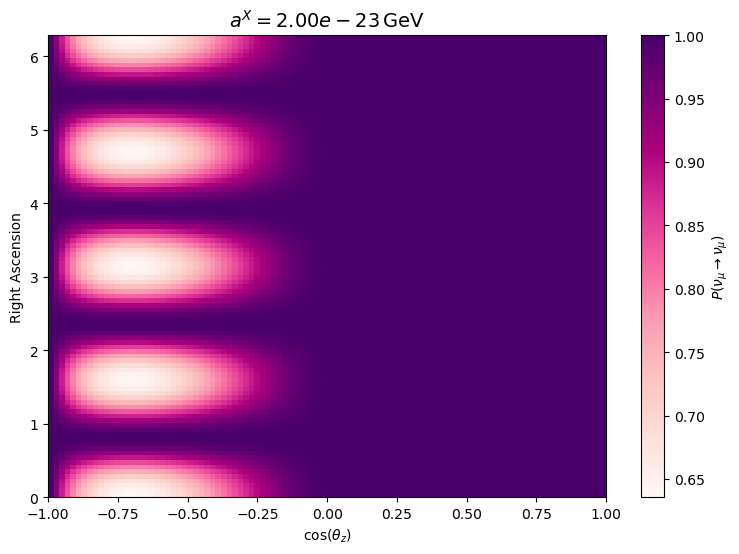

In [84]:
plt.figure(figsize=(9,6))
zenithBins = np.linspace(-1,1,100)
alphaBins = np.linspace(0,2*np.pi,100)
probabilities2d = np.zeros((100,100))
a = [2e-23,0]
c = [0,0]
for i in range(100): 
    for j in range(100): 
        probabilities2d[i,j] = pnunu(a,c,np.arccos(zenithBins[j]),alphaBins[i],1e3)
print(probabilities2d[10,50])
#hist = np.histogram2d(zenithBins,alphaBins,bins = [zenithBins,alphaBins],weights = probabilities2d)
plt.imshow(probabilities2d,aspect = 'auto',extent = [-1,1,0,2*np.pi],cmap = 'RdPu',vmax = 1)
plt.colorbar(label = r'$P(\nu_{\mu}\rightarrow \nu_{\mu})$')
plt.xlabel(r'$\cos(\theta_z)$')
plt.ylabel("Right Ascension")
plt.title(r'$a^X = {:.2e} \, \rm GeV$'.format(a[0]),fontsize = 14)
plt.show()

In [85]:
plt.figure(figsize=(9,6))
zenithBins = np.linspace(-1,1,100)
alphaBins = np.linspace(0,2*np.pi,100)
probabilities2d = np.zeros((100,100))
a = [0,0]
c = c_array[5]
for i in range(100): 
    for j in range(100): 
        probabilities2d[i,j] = pnunu(a,c,np.arccos(zenithBins[j]),alphaBins[i],1e3)
print(probabilities2d[10,50])
#hist = np.histogram2d(zenithBins,alphaBins,bins = [zenithBins,alphaBins],weights = probabilities2d)
plt.imshow(probabilities2d,aspect = 'auto',extent = [-1,1,0,2*np.pi],cmap = 'RdPu',vmax = 1)
plt.colorbar(label = r'$P(\nu_{\mu}\rightarrow \nu_{\mu})$')
plt.xlabel(r'$\cos(\theta_z)$')
plt.ylabel("Right Ascension")
plt.title(r'$a^X = {:.2e} \, \rm GeV$'.format(a[0])+r', $c^X = {:.2e}$'.format(c[0])+r', $c^Y = {:.2e}$'.format(c[1]),fontsize = 14)
plt.show()

0.9999998452728788


0.35510511541941114


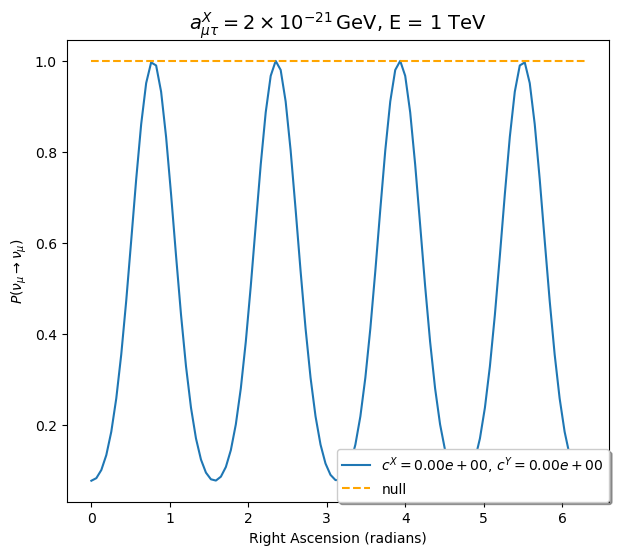

In [86]:
plt.figure(figsize=(7,6))
alphaBins = np.linspace(0,2*np.pi,100)
a = [2e-20,0]
c = [0,0]
cNull = [0,0]
aNull = [0,0]
probabilitiesNull = []
probabilities = []
for alpha in alphaBins:
    probabilities.append(pnunu(a,c,2.5+np.pi,alpha,1e3))
plt.plot(alphaBins,probabilities,label = r'$c^X = {:.2e}$'.format(c[0])+r', $c^Y = {:.2e}$'.format(c[1]))
for alpha in alphaBins:
    probabilitiesNull.append(pnunu(aNull,cNull,2.5+np.pi,alpha,1e3))
plt.plot(alphaBins,probabilitiesNull,color = 'orange',ls = '--',label = 'null')
print(probabilities[6])
#plt.xscale('log')
plt.xlabel("Right Ascension (radians)")
plt.title(r"$a_{\mu\tau}^X = 2\times 10^{-21}\, \rm GeV$, E = 1 TeV",fontsize = 14)
plt.ylabel(r"$P(\nu_{\mu}\rightarrow \nu_{\mu})$")
plt.legend( loc='lower right', borderaxespad=0.,frameon = True,shadow = True)
plt.show()

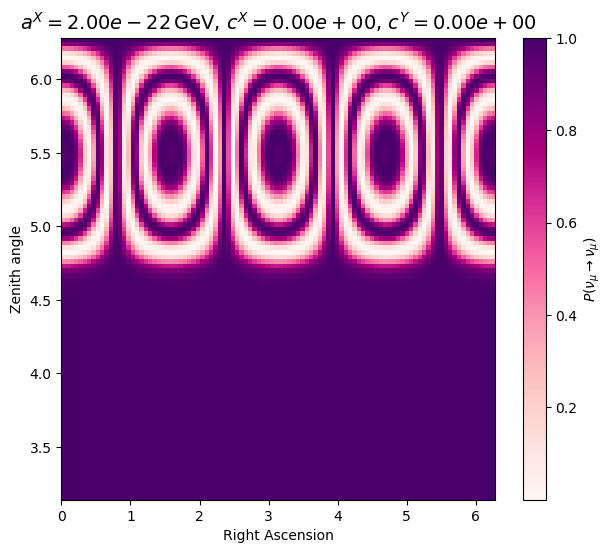

In [87]:
plt.figure(figsize=(7,6))
zenithBins = np.linspace(np.pi,2*np.pi,100)
alphaBins = np.linspace(0,2*np.pi,100)
probabilities2d = np.zeros((100,100))
a = [2e-22,0]
#c = c_array[0]
c = [0,0]
for i in range(100): 
    for j in range(100): 
        probabilities2d[i,j] = pnunu(a,c_array[0],zenithBins[j],alphaBins[i],1e4)
plt.imshow(probabilities2d.T,aspect = 'auto',extent = [0,2*np.pi,np.pi,2*np.pi],cmap = 'RdPu')
plt.colorbar(label = r'$P(\nu_{\mu}\rightarrow \nu_{\mu})$')
plt.ylabel('Zenith angle')
plt.xlabel("Right Ascension")
plt.title(r'$a^X = {:.2e} \, \rm GeV$'.format(a[0])+r', $c^X = {:.2e}$'.format(c[0])+r', $c^Y = {:.2e}$'.format(c[1]),fontsize = 14)
plt.show()

In [88]:
plt.figure(figsize=(7,6))
zenithBins = np.linspace(0,np.pi,100)
alphaBins = np.linspace(0,2*np.pi,100)
probabilities2d = np.zeros((100,100))
a = [2e-20,0]
c = c_array[1]
for i in range(100): 
    for j in range(100): 
        probabilities2d[i,j] = pnunu(a,c_array[0],zenithBins[j],alphaBins[i],1e4)
#hist = np.histogram2d(zenithBins,alphaBins,bins = [zenithBins,alphaBins],weights = probabilities2d)
plt.imshow(probabilities2d.T,aspect = 'auto',extent = [0,2*np.pi,0,np.pi],cmap = 'RdPu')
plt.colorbar(label = r'$P(\nu_{\mu}\rightarrow \nu_{\mu})$')
plt.ylabel('Zenith angle')
plt.xlabel("Right Ascension")
plt.title(r'$a^X = {:.2e} \, \rm GeV$'.format(a[0])+r', $c^X = {:.2e}$'.format(c[0])+r', $c^Y = {:.2e}$'.format(c[1]),fontsize = 14)
plt.show()